In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Bidirectional, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam


In [2]:
X_train=np.load("../data/X_train_scaled.npy")
X_test=np.load("../data/X_test_scaled.npy")
y_train=np.load("../data/y_train.npy")
y_test=np.load("../data/y_test.npy")

In [3]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (87554, 187, 1)
X_test: (21892, 187, 1)
y_train: (87554,)
y_test: (21892,)


## Handling Class Imbalance

Our dataset is highly imbalanced:

- **Normal beats:** ~83% of total samples  
- **Rare arrhythmias:** Only 1–8% each  

Without addressing this, the model might simply predict "Normal" for most heartbeats and still achieve high but misleading accuracy.

---

### Solution: Class Weighting
Class weights are numerical values that tell the model how important each class is during training.  
- Classes with **fewer samples** are given **higher weights**, meaning their errors contribute more to the loss.  
- Classes with **many samples** get **lower weights**, reducing their dominance during learning.

We assign higher importance (weights) to underrepresented classes during training.  
This helps the model pay more attention to rare arrhythmia types.

We use `sklearn.utils.class_weight.compute_class_weight` to automatically calculate class weights based on class frequencies.

In [4]:
class_weights=compute_class_weight(class_weight='balanced',classes=np.unique(y_train),y=y_train)
class_weights=dict(enumerate(class_weights))

print("Computed Class Weights:")
for i,w in class_weights.items():
    print(f"Class {i}: {w:.4f}")

Computed Class Weights:
Class 0: 0.2416
Class 1: 7.8771
Class 2: 3.0254
Class 3: 27.3179
Class 4: 2.7229


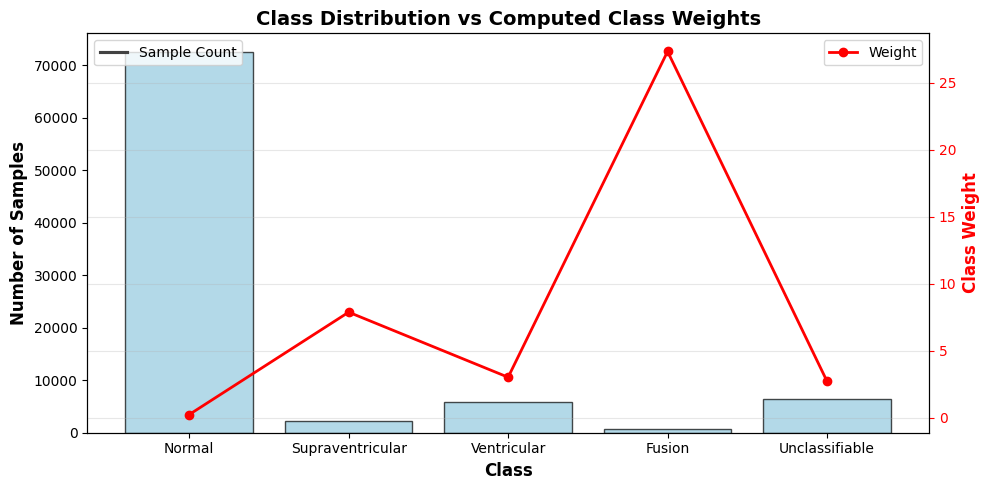

In [5]:
unique_classes, class_counts = np.unique(y_train, return_counts=True)

plt.figure(figsize=(10,5))

ax = sns.barplot(x=unique_classes, y=class_counts, color='skyblue', alpha=0.7, edgecolor='black')
ax.set_ylabel("Number of Samples", fontsize=12, fontweight='bold')
ax.set_xlabel("Class", fontsize=12, fontweight='bold')
ax.set_title("Class Distribution vs Computed Class Weights", fontsize=14, fontweight='bold')

ax2 = ax.twinx()
ax2.plot(unique_classes, [class_weights[i] for i in unique_classes], color='red', marker='o', linewidth=2, label='Class Weight')

ax2.set_ylabel("Class Weight", fontsize=12, fontweight='bold', color='red')
ax2.tick_params(axis='y', colors='red')

ax.set_xticks(unique_classes)
ax.set_xticklabels(['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unclassifiable'])

ax.legend(['Sample Count'], loc='upper left')
ax2.legend(['Weight'], loc='upper right')

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


## Defining CNN–BiLSTM Model

We design a **hybrid CNN–BiLSTM architecture** that effectively combines spatial feature extraction (via CNN) and temporal sequence modeling (via BiLSTM). This hybrid structure is particularly well-suited for **ECG arrhythmia classification**, where both waveform shape and rhythm context matter.

---

### Hybrid Architecture Overview

- **CNN layers** extract **local morphological features** from ECG signals (e.g., QRS complexes, wave peaks, and shapes).  
- **Bidirectional LSTMs** capture **temporal dependencies**, learning how signals evolve over time in both directions.  
- **Fully Connected layers** perform the final classification into heartbeat categories.

---

### CNN Blocks (Feature Extraction)

The model employs **three convolutional blocks**, each with progressively deeper filters:

| Block | Conv Filters | Components |
|:--|:--|:--|
| **Block 1** | 32 filters | Conv1D → BatchNorm → ReLU → MaxPooling(2) → Dropout(0.2) |
| **Block 2** | 64 filters | Conv1D → BatchNorm → ReLU → MaxPooling(2) → Dropout(0.2) |
| **Block 3** | 128 filters | Conv1D → BatchNorm → ReLU → MaxPooling(2) → Dropout(0.2) |

**Why CNN?**  
CNNs are excellent at identifying **local spatial features** such as waveform shapes, spikes, and irregular amplitudes — all of which are critical for distinguishing between normal and abnormal ECG patterns.

---

### LSTM Layers (Temporal Pattern Learning)

After spatial features are extracted, the sequence is passed to **Bidirectional LSTM layers**:

- **Two BiLSTM layers** with **64 units** each  
- **First layer:** `return_sequences=True` → passes full temporal sequence  
- **Second layer:** `return_sequences=False` → outputs final sequence representation  
- **Dropout (0.3)** applied between LSTM layers for regularization  

**Why BiLSTM?**  
Bidirectional processing allows the model to understand **dependencies in both past and future timesteps**, improving rhythm-based decision-making in ECG signals.

---

### Fully Connected Layers

Final dense layers translate the learned sequence representation into class probabilities:

- **Dense (64, ReLU)** → nonlinear transformation of learned features  
- **Dropout (0.5)** → stronger regularization to avoid overfitting  
- **Dense (5, Softmax)** → outputs probability distribution across 5 heartbeat classes  

---

### Model Summary

- **Input Shape:** (187, 1) — single-channel ECG signal segment  
- **Output Shape:** (5,) — class probabilities for heartbeat types  
- **Total Parameters:** ≈ 500K (trainable)

---

### Why This Architecture Works

- **CNN layers** detect **spatial ECG morphology** — shapes of individual heartbeats.  
- **BiLSTM layers** model **temporal dependencies** — rhythm and beat-to-beat variations.  
- **Dropout + BatchNorm** stabilize training and reduce overfitting.  
- The combined approach leverages **both spatial and temporal features**, leading to more robust arrhythmia classification.

---

**In essence:**  
This CNN–BiLSTM hybrid architecture efficiently captures both **what** happens within each heartbeat and **how** heartbeats change over time — a crucial combination for accurate ECG-based diagnosis.

In [7]:
model=Sequential([
    # Input Layer
    Input(shape=(187, 1)),

    # CNN Block 1
    Conv1D(filters=32,kernel_size=5,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # CNN Block 2
    Conv1D(filters=64,kernel_size=5,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # CNN Block 3
    Conv1D(filters=128,kernel_size=5,activation='relu',padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),

    # LSTM Layers
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=False)),

    # Fully Connected Layer
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(5,activation='softmax')
]) 

In [8]:
model.compile(optimizer='Adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 187, 32)        │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 187, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 93, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 93, 64)         │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 93, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 46, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 46, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 46, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 23, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 23, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,693 (1010.52 KB)

 Trainable params: 258,245 (1008.77 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
early_stop=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)

In [12]:
scheduler=ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=5,verbose=1)

In [13]:
checkpoint=ModelCheckpoint(
    filepath="../models/cnn_lstm_best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [15]:
history=model.fit(
    X_train,y_train,
    validation_data=(X_test,y_test),
    epochs=50,
    batch_size=64,
    class_weight=class_weights,
    callbacks=[early_stop,scheduler,checkpoint],
    verbose=1
)

Epoch 1/50


2025-11-07 03:43:59.931283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.5292 - loss: 0.8930
Epoch 1: val_loss improved from None to 0.44300, saving model to ../models/cnn_lstm_best_model.keras
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 147s 103ms/step - accuracy: 0.6568 - loss: 0.6675 - val_accuracy: 0.8619 - val_loss: 0.4430 - learning_rate: 0.0010
Epoch 2/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.7898 - loss: 0.4552
Epoch 2: val_loss did not improve from 0.44300
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 141s 103ms/step - accuracy: 0.8122 - loss: 0.4120 - val_accuracy: 0.8494 - val_loss: 0.4459 - learning_rate: 0.0010
Epoch 3/50
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8407 - loss: 0.3683
Epoch 3: val_loss improved from 0.44300 to 0.36045, saving model to ../models/cnn_lstm_best_model.keras
1369/1369 ━━━━━━━━━━━━━━━━━━━━ 140s 102ms/step - accuracy: 0.8478 - loss: 0.3513 - val_accuracy: 0.8944 - val_loss: 0.3604 - learning_rate: 0.0010
Epoch 4/50
1368/1369 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/s

In [16]:
from tensorflow.keras.models import load_model

best_model=load_model("../models/cnn_lstm_best_model.keras")
print("Best model loaded successfully!")

Best model loaded successfully!


In [17]:
test_loss,test_accuracy=best_model.evaluate(X_test,y_test,verbose=1)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

685/685 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - accuracy: 0.9691 - loss: 0.1014
Test Accuracy: 96.91%
Test Loss: 0.1014


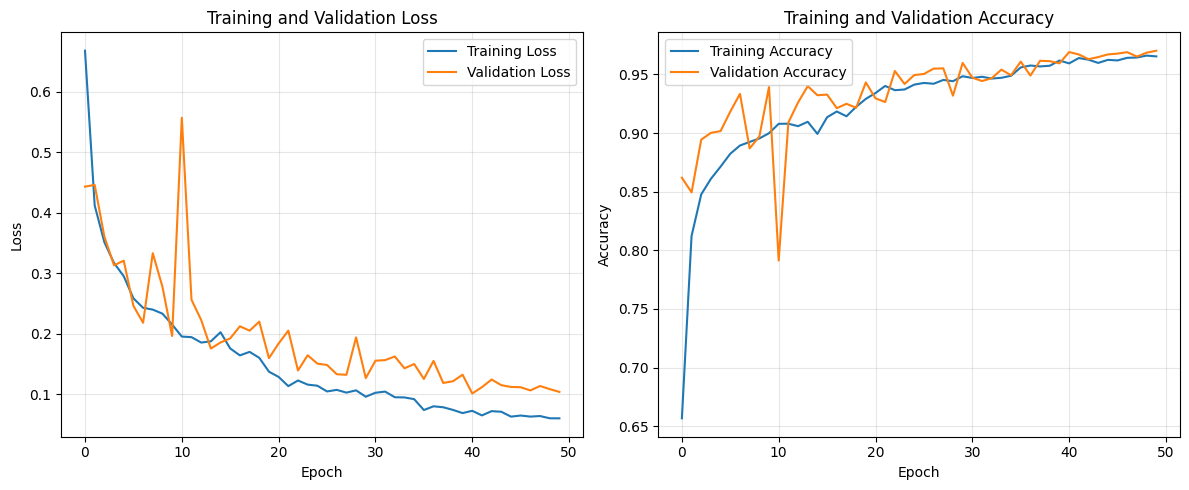

In [19]:
plt.figure(figsize=(12,5))

# Loss plot
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy plot
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

685/685 ━━━━━━━━━━━━━━━━━━━━ 16s 23ms/step

Classification Report:

                  precision    recall  f1-score   support

          Normal       1.00      0.97      0.98     18118
Supraventricular       0.58      0.88      0.70       556
     Ventricular       0.94      0.96      0.95      1448
          Fusion       0.54      0.90      0.67       162
  Unclassifiable       0.98      0.99      0.99      1608

        accuracy                           0.97     21892
       macro avg       0.81      0.94      0.86     21892
    weighted avg       0.98      0.97      0.97     21892



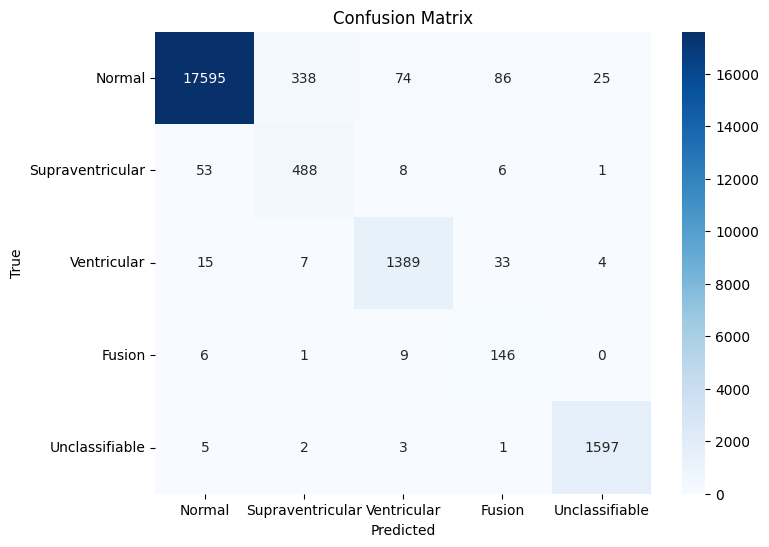

In [20]:
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=[
    'Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unclassifiable'
]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Supraventricular','Ventricular','Fusion','Unclassifiable'],
            yticklabels=['Normal','Supraventricular','Ventricular','Fusion','Unclassifiable'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

ROC CURVES – MULTICLASS


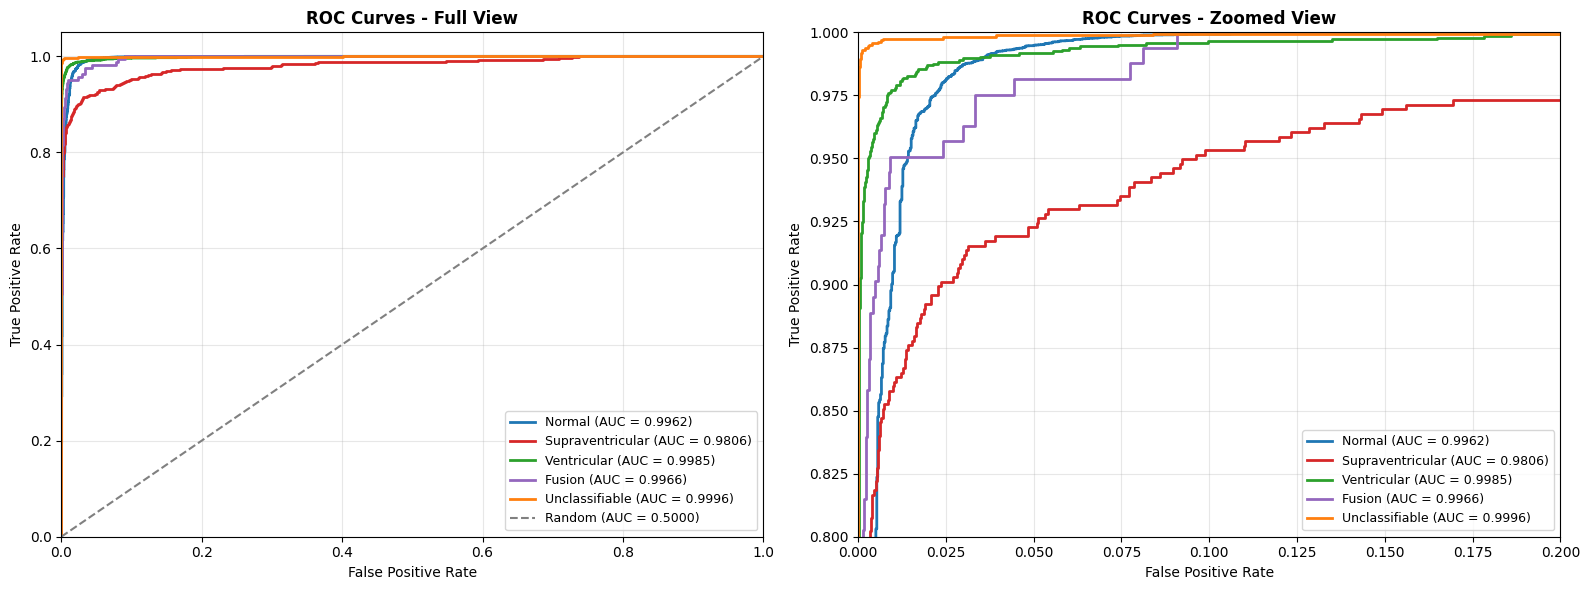


Macro-Averaged AUC:  0.9943
Micro-Averaged AUC:  0.9984


In [25]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

print("==========================================")
print("ROC CURVES – MULTICLASS")
print("==========================================")

class_names = ['Normal', 'Supraventricular', 'Ventricular', 'Fusion', 'Unclassifiable']

y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])
n_classes = y_test_bin.shape[1]

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

fig, ax = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#1f77b4', '#d62728', '#2ca02c', '#9467bd', '#ff7f0e']

for i, color in zip(range(n_classes), colors):
    ax[0].plot(fpr[i], tpr[i], color=color, lw=2,
               label=f"{class_names[i]} (AUC = {roc_auc[i]:.4f})")

ax[0].plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='gray', label='Random (AUC = 0.5000)')

ax[0].set_xlim([0.0, 1.0])
ax[0].set_ylim([0.0, 1.05])
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].set_title('ROC Curves - Full View', fontweight='bold')
ax[0].legend(loc='lower right', fontsize=9)
ax[0].grid(alpha=0.3)

for i, color in zip(range(n_classes), colors):
    ax[1].plot(fpr[i], tpr[i], color=color, lw=2,
               label=f"{class_names[i]} (AUC = {roc_auc[i]:.4f})")

ax[1].plot([0, 1], [0, 1], linestyle='--', lw=1.5, color='gray')

ax[1].set_xlim([0.0, 0.2])   
ax[1].set_ylim([0.8, 1.0])   
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')
ax[1].set_title('ROC Curves - Zoomed View', fontweight='bold')
ax[1].legend(loc='lower right', fontsize=9)
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

macro_auc = roc_auc_score(y_test_bin, y_pred_probs, average='macro')
print(f"\nMacro-Averaged AUC:  {macro_auc:.4f}")
print(f"Micro-Averaged AUC:  {roc_auc['micro']:.4f}")

In [29]:
auc_per_class = []
for i, name in enumerate(class_names):
    auc_score = roc_auc_score(y_test_bin[:, i], y_pred_probs[:, i])
    auc_per_class.append((name, auc_score))

print("Area Under Curve (AUC) per class:")
for name, score in auc_per_class:
    print(f"  {name:<20s}: {score:.4f}")

Area Under Curve (AUC) per class:
  Normal              : 0.9962
  Supraventricular    : 0.9806
  Ventricular         : 0.9985
  Fusion              : 0.9966
  Unclassifiable      : 0.9996


In [30]:
# Prediction on new data 
sample_index = np.random.randint(0, len(X_test))
sample_signal = X_test[sample_index]
true_label = y_test[sample_index]

sample_input = np.expand_dims(sample_signal, axis=0)

# Predict using the trained model
pred_probs = best_model.predict(sample_input)
pred_class = np.argmax(pred_probs, axis=1)[0]

print("=== SAMPLE PREDICTION RESULT ===")
print(f"Sample Index       : {sample_index}")
print(f"True Label         : {class_names[true_label]}")
print(f"Predicted Label    : {class_names[pred_class]}")
print(f"\nPrediction Probabilities:")
for i, cls in enumerate(class_names):
    print(f"{cls:<20s}: {pred_probs[0][i]*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 927ms/step
=== SAMPLE PREDICTION RESULT ===
Sample Index       : 10941
True Label         : Normal
Predicted Label    : Normal

Prediction Probabilities:
Normal              : 100.00%
Supraventricular    : 0.00%
Ventricular         : 0.00%
Fusion              : 0.00%
Unclassifiable      : 0.00%


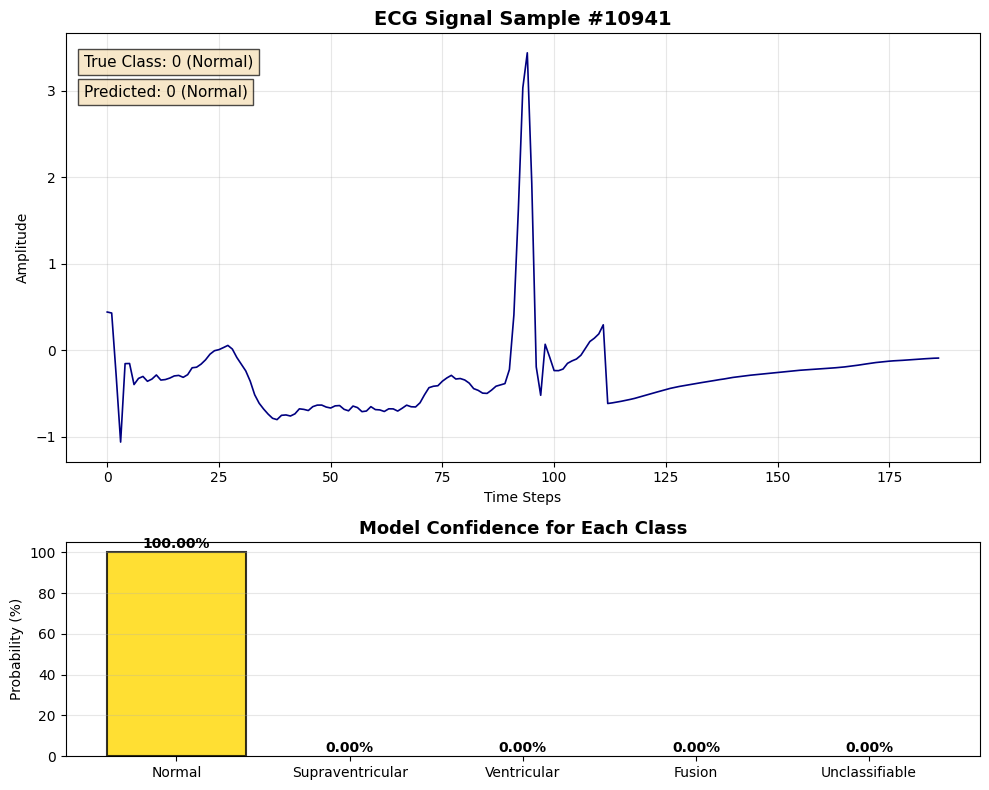

In [32]:
# Visualize the signal
fig, ax = plt.subplots(2, 1, figsize=(10, 8), gridspec_kw={'height_ratios': [2, 1]})

# ECG Signal Plot
ax[0].plot(sample_signal, color='navy', linewidth=1.2)
ax[0].set_title(f"ECG Signal Sample #{sample_index}", fontsize=14, fontweight='bold')
ax[0].set_xlabel("Time Steps")
ax[0].set_ylabel("Amplitude")
ax[0].grid(alpha=0.3)

ax[0].text(0.02, 0.95, f"True Class: {true_label} ({class_names[true_label]})",
           transform=ax[0].transAxes, fontsize=11,
           verticalalignment='top', bbox=dict(facecolor='wheat', alpha=0.7))
ax[0].text(0.02, 0.88, f"Predicted: {pred_class} ({class_names[pred_class]})",
           transform=ax[0].transAxes, fontsize=11,
           verticalalignment='top', bbox=dict(facecolor='wheat', alpha=0.7))

# Model Confidence Bar Chart
bars = ax[1].bar(range(len(class_names)), pred_probs[0]*100, color='seagreen', alpha=0.8)
ax[1].set_xticks(range(len(class_names)))
ax[1].set_xticklabels(class_names)
ax[1].set_ylim([0, 105])
ax[1].set_ylabel("Probability (%)")
ax[1].set_title("Model Confidence for Each Class", fontsize=13, fontweight='bold')
ax[1].grid(axis='y', alpha=0.3)

bars[pred_class].set_color('gold')
bars[pred_class].set_edgecolor('black')
bars[pred_class].set_linewidth(1.5)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax[1].text(bar.get_x() + bar.get_width()/2, height + 2,
               f"{height:.2f}%", ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()